In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image, display
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import re
import ast
from pathlib import Path

from behavioral_profiling import behavioral_data_processing, get_segment_profile_data
from segment_profiler import get_segment_profile_data

##  Project Objective
Perform behavioral pattern analysis to understand differences in product usage, transaction history, and digital engagement across customer segments.

##  Goal
Use the insights to recommend targeted marketing strategies and improve campaign effectiveness.


##  Data Overview

In [3]:
df = behavioral_data_processing()
df.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,...,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion,Cluster_Label,email_ctr,engagement_depth,social_propensity
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,...,19,6,9,4,688,1,3,1.500000,17.745052,0.000000
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,...,5,2,7,2,3459,1,2,3.500000,15.614122,0.119048
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,...,0,11,2,8,2337,1,3,0.181818,113.444015,0.000000
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,...,89,2,2,0,2463,1,4,1.000000,66.698958,1.893617
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,...,6,6,6,8,4345,1,4,1.000000,28.642290,0.000000


### Feature Engineering

- **Email Click-Through Rate (CTR)**
  - **What it does:** Calculates the ratio of `EmailClicks` to `EmailOpens`.
  - **How it works:** Applies a lambda function to each row: if `EmailOpens` > 0, then CTR = `EmailClicks` / `EmailOpens`; otherwise, it returns 0.
  - **Why it's useful:** Measures email engagement effectiveness by showing how often opened emails lead to clicks.

- **Website Engagement Depth**
  - **What it does:** Combines the number of pages visited and the time spent on the website into a single metric.
  - **How it works:** Multiplies `PagesPerVisit` by `TimeOnSite` for each record.
  - **Why it's useful:** Captures both the breadth (pages visited) and depth (time spent) of user engagement, providing a comprehensive measure of interaction.

- **Social Sharing Propensity**
  - **What it does:** Computes the ratio of `SocialShares` to `WebsiteVisits`.
  - **How it works:** Uses a lambda function for each row: if `WebsiteVisits` > 0, then propensity = `SocialShares` / `WebsiteVisits`; otherwise, it returns 0.
  - **Why it's useful:** Indicates how likely customers are to share content, which can drive organic growth and enhance word-of-mouth marketing.

## Comparison Across All Segments

In [12]:
# Import visualization functions from segment_visualizer.py
from segment_visualizer import (
    extract_numeric,
    normalize_value,
    create_segment_size_distribution,
    create_features_comparison_chart,
    create_radar_comparison_chart,
    create_value_metrics_comparison,
    create_preferences_comparison,
    PROFILE_JSON  # Import default profile path
)

# Set output directory
OUTPUT_DIR = 'segment_visualizations'

# Function to load profile data
def load_profile_data(profile_json_path=PROFILE_JSON):
    """
    Load profile data from JSON file.
    """
    # If profiles.json doesn't exist, try to use the segment_profiler to generate it
    if not os.path.exists(profile_json_path):
        try:
            # Try to import the behavioral data processing module
            from data_processing import behavioral_data_processing
            
            # Check if input data file exists
            input_data_file = 'customer_data.csv'
            if os.path.exists(input_data_file):
                print(f"Processing data from {input_data_file}...")
                processed_df = behavioral_data_processing(input_data_file)
                
                # Get segment profile data
                print("Generating segment profiles...")
                profile_data = get_segment_profile_data(processed_df)
                
                # Save profile data to JSON
                with open(profile_json_path, 'w') as f:
                    json.dump(profile_data, f, indent=4)
                
                print(f"Profile data saved to {profile_json_path}")
                return profile_data
            else:
                raise FileNotFoundError(f"Input data file not found: {input_data_file}")
        except (ImportError, FileNotFoundError) as e:
            print(f"Error: {e}")
            print("Please make sure the behavioral data processing module is available.")
            return None
    
    # Load profile data from JSON
    try:
        with open(profile_json_path, 'r') as f:
            profile_data = json.load(f)
        
        return profile_data
    except Exception as e:
        print(f"Error loading profile data: {e}")
        return None




In [16]:
# Create visualizations directly in the notebook
def display_segment_visualizations(profile_data, output_dir=OUTPUT_DIR):
    """
    Create and display all segment visualizations in the notebook.
    Also saves the visualizations to files.
    """
    if profile_data is None:
        print("Error: No profile data available.")
        return
    
    # Get segment IDs
    segments = list(profile_data.keys())
    
    # Create output directory for visualizations
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # 1. Segment Size Distribution
    print("\n## Segment Size Distribution")
    print("This visualization shows the relative size of each customer segment.")
    size_path = os.path.join(output_dir, 'segment_size_distribution.png')
    fig_size = plt.figure()
    create_segment_size_distribution(segments, profile_data, size_path)
    img_size = plt.imread(size_path)
    plt.imshow(img_size)
    plt.axis('off')
    plt.tight_layout()
    display(plt.gcf())
    plt.close()
    
    # 2. Features Comparison
    print("\n## Feature Importance by Segment")
    print("This visualization shows the top features for each segment and how they deviate from the average.")
    features_path = os.path.join(output_dir, 'features_comparison.png')
    fig_features = plt.figure()
    create_features_comparison_chart(segments, profile_data, features_path)
    img_features = plt.imread(features_path)
    plt.imshow(img_features)
    plt.axis('off')
    plt.tight_layout()
    display(plt.gcf())
    plt.close()
    
    # 3. Radar Chart Comparison
    print("\n## Digital Engagement Patterns")
    print("This radar chart shows how different segments compare across various engagement metrics.")
    radar_path = os.path.join(output_dir, 'engagement_radar_comparison.png')
    fig_radar = plt.figure()
    create_radar_comparison_chart(segments, profile_data, radar_path)
    img_radar = plt.imread(radar_path)
    plt.imshow(img_radar)
    plt.axis('off')
    plt.tight_layout()
    display(plt.gcf())
    plt.close()
    
    # 4. Value Metrics Comparison
    print("\n## Value Metrics Comparison")
    print("This table shows key value metrics for each segment, with color intensity indicating higher values.")
    metrics_path = os.path.join(output_dir, 'value_metrics_comparison.png')
    fig_metrics = plt.figure()
    create_value_metrics_comparison(segments, profile_data, metrics_path)
    img_metrics = plt.imread(metrics_path)
    plt.imshow(img_metrics)
    plt.axis('off')
    plt.tight_layout()
    display(plt.gcf())
    plt.close()
    
    # 5. Preferences Comparison
    print("\n## Channel and Campaign Preferences")
    print("These pie charts show the distribution of channels and campaign types for each segment.")
    preferences_path = os.path.join(output_dir, 'preferences_comparison.png')
    fig_prefs = plt.figure()
    create_preferences_comparison(segments, profile_data, preferences_path)
    img_prefs = plt.imread(preferences_path)
    plt.imshow(img_prefs)
    plt.axis('off')
    plt.tight_layout()
    display(plt.gcf())
    plt.close()
    
    print("\nAll visualizations created successfully!")

In [17]:
# Display key insights from the data
def display_segment_insights(profile_data):
    if profile_data is None:
        print("Error: No profile data available.")
        return
    
    segments = list(profile_data.keys())
    
    print("\n## KEY INSIGHTS FROM SEGMENT ANALYSIS\n")
    
    # Group segments by conversion rate
    high_conv_segments = []
    low_conv_segments = []
    
    for segment in segments:
        conv_rate = extract_numeric(profile_data[segment]['value_metrics']['conversion_rate'])
        if conv_rate > 50:
            high_conv_segments.append(segment)
        else:
            low_conv_segments.append(segment)
    
    print(f"### Segment Conversion Analysis")
    print(f"- High-converting segments ({len(high_conv_segments)}): {', '.join(high_conv_segments)}")
    print(f"- Low-converting segments ({len(low_conv_segments)}): {', '.join(low_conv_segments)}")
    
    # Show segment sizes
    print("\n### Segment Size Analysis")
    for segment in segments:
        size_info = profile_data[segment]['size']
        count = extract_numeric(size_info.get('count', 0))
        percentage = extract_numeric(size_info.get('percentage', '0%'))
        print(f"- Segment {segment}: {int(count)} customers ({percentage:.1f}%)")
    
    # Show best channels and campaigns
    print("\n### Marketing Channel Analysis")
    for segment in segments:
        best_channel = profile_data[segment]['channel_preferences']['best_channel']
        best_channel_conv = profile_data[segment]['channel_preferences']['best_channel_conversion']
        print(f"- Segment {segment}: Best channel is {best_channel} with {best_channel_conv} conversion rate")
    
    print("\n### Campaign Type Analysis")
    for segment in segments:
        best_campaign = profile_data[segment]['campaign_preferences']['best_campaign']
        best_campaign_conv = profile_data[segment]['campaign_preferences']['best_campaign_conversion']
        print(f"- Segment {segment}: Best campaign type is {best_campaign} with {best_campaign_conv} conversion rate")
    
    # Show top features for high-converting segments
    print("\n### Key Features Driving Conversion in High-Performing Segments")
    for segment in high_conv_segments:
        print(f"\nSegment {segment} top features:")
        top_features = profile_data[segment]['top_features']
        if isinstance(top_features, str):
            try:
                top_features = ast.literal_eval(top_features)
            except:
                top_features = []
        
        for feat in top_features[:3]:  # Show top 3 features
            feature = feat.get('feature', '')
            deviation = extract_numeric(feat.get('deviation', 0))
            direction = feat.get('direction', '')
            print(f"  - {feature}: {deviation:.1f}% {direction} than average")

# Customer Segment Analysis Dashboard
This notebook presents a comprehensive analysis of customer segments based on their behavior and preferences.

## Loading Segment Profile Data
Successfully loaded profile data for 6 segments.

## Segment Size Distribution
This visualization shows the relative size of each customer segment.
Created segment size distribution chart at: segment_visualizations/segment_size_distribution.png


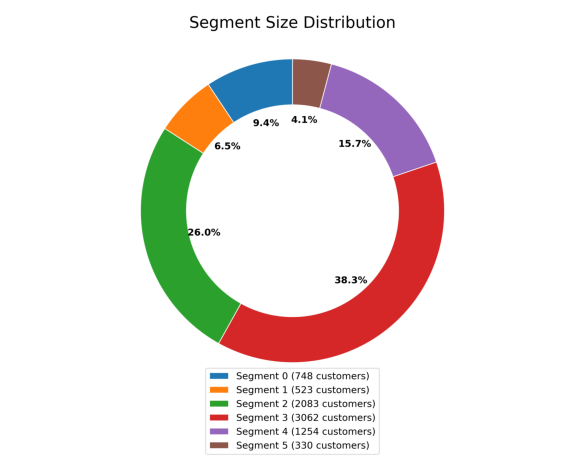


## Feature Importance by Segment
This visualization shows the top features for each segment and how they deviate from the average.
Created features comparison chart at: segment_visualizations/features_comparison.png


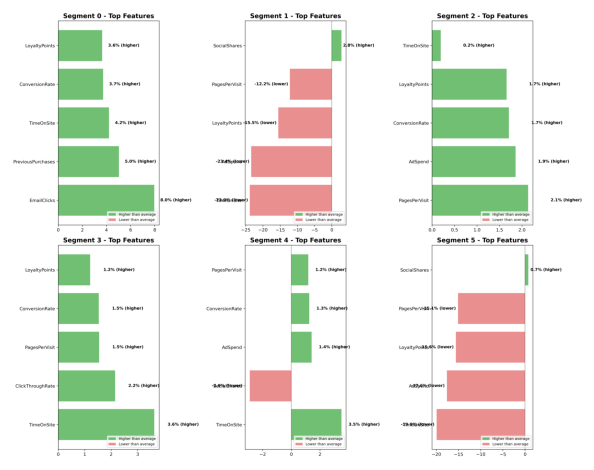


## Digital Engagement Patterns
This radar chart shows how different segments compare across various engagement metrics.
Created radar comparison chart at: segment_visualizations/engagement_radar_comparison.png


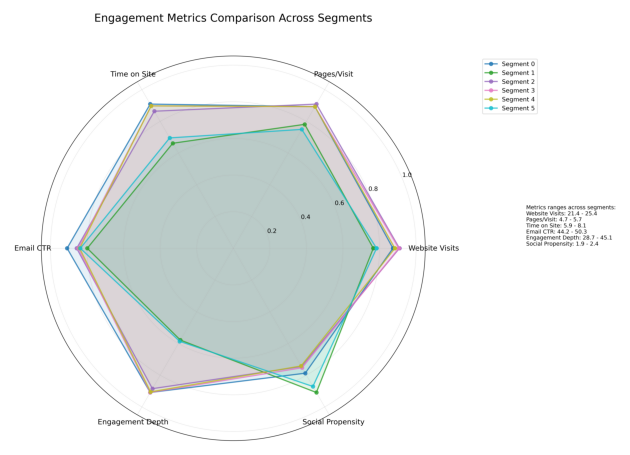


## Value Metrics Comparison
This table shows key value metrics for each segment, with color intensity indicating higher values.
Created value metrics comparison at: segment_visualizations/value_metrics_comparison.png


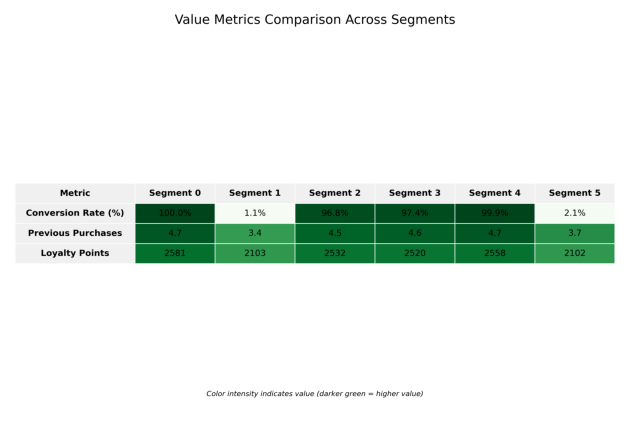


## Channel and Campaign Preferences
These pie charts show the distribution of channels and campaign types for each segment.
Created preferences comparison chart at: segment_visualizations/preferences_comparison.png


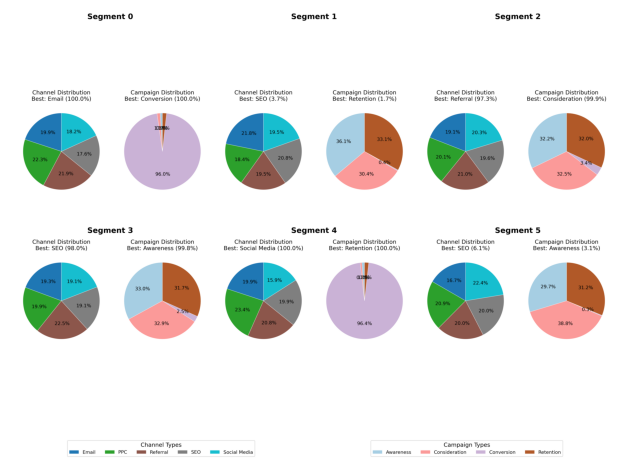


All visualizations created successfully!

## KEY INSIGHTS FROM SEGMENT ANALYSIS

### Segment Conversion Analysis
- High-converting segments (4): 0, 2, 3, 4
- Low-converting segments (2): 1, 5

### Segment Size Analysis
- Segment 0: 748 customers (9.3%)
- Segment 1: 523 customers (6.5%)
- Segment 2: 2083 customers (26.0%)
- Segment 3: 3062 customers (38.3%)
- Segment 4: 1254 customers (15.7%)
- Segment 5: 330 customers (4.1%)

### Marketing Channel Analysis
- Segment 0: Best channel is Email with 100.0% conversion rate
- Segment 1: Best channel is SEO with 3.7% conversion rate
- Segment 2: Best channel is Referral with 97.3% conversion rate
- Segment 3: Best channel is SEO with 98.0% conversion rate
- Segment 4: Best channel is Social Media with 100.0% conversion rate
- Segment 5: Best channel is SEO with 6.1% conversion rate

### Campaign Type Analysis
- Segment 0: Best campaign type is Conversion with 100.0% conversion rate
- Segment 1: Best campaign type is Retention with 1.7% conve

In [18]:
# Main section
print("# Customer Segment Analysis Dashboard")
print("This notebook presents a comprehensive analysis of customer segments based on their behavior and preferences.")

# Load the data
print("\n## Loading Segment Profile Data")
profile_data = load_profile_data(PROFILE_JSON)

if profile_data:
    print(f"Successfully loaded profile data for {len(profile_data)} segments.")
    
    # Display visualizations
    display_segment_visualizations(profile_data)
    
    # Display insights
    display_segment_insights(profile_data)
else:
    print("Failed to load profile data. Please ensure the profiles.json file exists or that segment_profiler.py can generate it.")

print("\n## Conclusion")
print("""
This segment analysis provides key insights for optimizing marketing strategies:

1. Target high-converting segments with well-tailored campaigns using their preferred channels
2. Use different approaches for different segments based on their unique characteristics
3. Focus budget allocation on the most responsive segments and channels
4. Develop strategies to improve engagement for lower-performing segments

The visualizations help identify patterns and opportunities across segments that would be difficult to spot in the raw data.
""")

## Targeted Marketing Recommendation For Each Segment


### Segment 0: **“High-Value Email Converters”**
- **Size:** Medium (748 customers, ~9.4%)  
- **Value:**  
  - **100% conversion rate** on relevant offers  
  - **Top loyalty points** and **highest purchase frequency**  
- **Engagement:** Strong across channels, especially **Email CTR**  
- **Preferences:** Leans heavily on **Email**; performs best in **Conversion**-focused campaigns  
- **Feature Usage:** High uptake on new product launches (e.g., credit cards, personal loans)

#### Strategy
- **Objective:** **Maximize ROI** by deepening relationships with already loyal, high-value customers  
- **Tactics:**  
  1. **Exclusive Email Campaigns**  
     - Offer targeted promotions (e.g., premium credit card upgrades, high-yield savings, mortgage refinance deals).  
     - Personalize subject lines with recent account activity or loyalty milestones.  
  2. **Tiered Loyalty Program**  
     - Provide perks like fee waivers on international transactions or priority customer service lines.  
     - Introduce early-access or beta testing for new financial products (e.g., robo-advisor pilot).  
  3. **Cross-Sell Initiatives**  
     - Leverage their trust in email to promote complementary products (e.g., auto loans, investment accounts).

---

### Segment 1: **“Disengaged Low-Value Floaters”**
- **Size:** Small (523 customers, ~6.5%)  
- **Value:**  
  - **Lowest conversion rate** (roughly 1–2%)  
  - Minimal loyalty point accumulation and few purchases  
- **Engagement:** Low time on site, minimal web visits, weak email responsiveness  
- **Preferences:** Slight SEO responsiveness; best approached via **Retention** campaigns  
- **Feature Usage:** Negligible usage of premium or advanced banking tools

#### Strategy
- **Objective:** **Re-engage** or reduce churn risk by highlighting easy wins and building basic trust  
- **Tactics:**  
  1. **Reactivation Offers**  
     - Waive service fees (e.g., first-year annual fees on credit cards).  
     - Provide short-term promos (e.g., “Open a checking account today, get \$50 reward”).  
  2. **SEO Retargeting & Educational Content**  
     - Promote “Basics of Banking” guides or personal finance tutorials in search results.  
     - Craft landing pages explaining fees, interest rates, and benefits in simple terms.  
  3. **Gamified App Onboarding**  
     - Encourage digital usage via small achievements (e.g., completing first online bill payment).  
     - Offer micro-deposit savings goals or round-up programs to boost account activity.

---

### Segment 2: **“Referral-Savvy Digital Researchers”**
- **Size:** Medium–Large (2083 customers, ~26%)  
- **Value:**  
  - **High conversion** (≈ 96.8%)  
  - Strong loyalty and decent purchase history  
- **Engagement:** Consistently **longer website sessions** (time on site, pages/visit)  
- **Preferences:** 97% referral-driven; thrives under **Consideration** campaigns  
- **Feature Usage:** Above-average usage of online research tools (e.g., loan calculators, interest rate comparison)

## Strategy
- **Objective:** Feed their research habit with **peer validation** and robust digital resources  
- **Tactics:**  
  1. **Referral & Social Proof**  
     - Incentivize them to invite friends/family (“Refer 2, get 500 loyalty points or \$XX cash bonus”).  
     - Use testimonials and user reviews to reinforce product benefits (e.g., “90% of customers save \$300/year”).  
  2. **In-App Decision Tools**  
     - Provide easy-to-use comparison widgets for loans, credit cards, and insurance.  
     - Incorporate personalized recommendations based on browsing or purchase patterns.  
  3. **Educational Webinars & Blogs**  
     - Host Q&A sessions on mortgages, savings strategies, or investment basics.  
     - Publish cost-benefit case studies showing how real customers used bank products effectively.

---

### Segment 3: **“Engaged Generalists & Growth Engine”**
- **Size:** Largest (3062 customers, ~38.3%)  
- **Value:**  
  - Consistently **top 3** in conversion, loyalty, and purchase frequency  
- **Engagement:** Strong cross-channel presence: high website click-through, multiple page views  
- **Preferences:** 98% SEO usage; strong response to **Awareness** campaigns  
- **Feature Usage:** Well-rounded utilization of checking, savings, credit, and possibly basic investment tools

#### Strategy
- **Objective:** **Drive brand expansion** and retain a wide audience of actively engaged customers  
- **Tactics:**  
  1. **Brand Storytelling & Thought Leadership**  
     - SEO-friendly blog posts on topics like future economic trends, personal finance hacks, or retirement planning.  
     - Humanize the brand with success stories and behind-the-scenes insights (e.g., “Meet our finance experts”).  
  2. **Early-Access or Pilot Programs**  
     - Invite them to test new mobile app features (e.g., advanced budgeting dashboards, voice-enabled banking).  
     - Offer loyalty bonuses for adopting “higher-tier” products (e.g., premium checking with interest).  
  3. **Targeted Sub-Segmentation**  
     - Within this large group, identify micro-segments (e.g., heavy credit card users vs. budding investors) for more specialized offers.  
     - Provide ongoing “tier upgrades” based on usage intensity.

---

### Segment 4: **“Social Media Loyalists with Retention Value”**
- **Size:** Mid-sized (1254 customers, ~15.7%)  
- **Value:**  
  - **99.9% conversion**, solid past purchase behavior, high loyalty  
- **Engagement:** Elevated across multiple metrics (time on site, engagement depth, social media interactions)  
- **Preferences:** 100% Social Media usage; thrives in **Retention**-focused campaigns  
- **Feature Usage:** Strong interest in credit products, loan expansions, online deposit channels

#### Strategy
- **Objective:** **Sustain loyalty** and leverage social influence  
- **Tactics:**  
  1. **Social Media Contests & Challenges**  
     - “Tag us with your financial goal” to earn bonus loyalty points.  
     - Live Q&A streams or influencer events to keep engagement high.  
  2. **Exclusive Social Perks**  
     - Monthly “secret deals” shared only on official social channels.  
     - Gamified mini-challenges (“Add \$100 to your savings, get X points”).  
  3. **Retention & Advocacy Push**  
     - Reward them for posting genuine reviews or success stories about your bank’s products.  
     - Encourage product expansions (e.g., from savings to mortgage) with limited-time social referral discounts.

---

### Segment 5: **“Low-Value Social Amplifiers”**
- **Size:** Smallest (330 customers, ~4.1%)  
- **Value:**  
  - **Low conversion** (~2.1%) and minimal loyalty  
  - Highest **Social Propensity** (shares, likes, mentions)  
- **Engagement:** Weak in direct product usage, but active in social conversations or brand mentions  
- **Preferences:** Slight SEO interest (~6.1%), best engaged through **Awareness** campaigns  
- **Feature Usage:** Rarely uses advanced banking features yet invests time in discussing them socially

#### Strategy
- **Objective:** Harness **brand awareness** without expecting major conversions  
- **Tactics:**  
  1. **Viral-Style Content & Giveaways**  
     - Short financial quizzes or meme-style infographics to spark social sharing.  
     - Monthly small-prize giveaways (e.g., coffee gift cards) for tag-and-share campaigns.  
  2. **Community Recognition**  
     - Shout-outs to top sharers (“Customer Spotlight of the Week”).  
     - Leaderboards or badges for consistent brand mentions.  
  3. **Soft Sales Approaches**  
     - Direct them to simple accounts or micro-saving products when they do express interest.  
     - Avoid pushy offers; focus on maintaining a positive brand image in their networks.


